In [1]:
from sklearn.model_selection import train_test_split
import torch
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from datetime import datetime
import torch.optim.lr_scheduler as sch

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from IPython.display import clear_output
from tqdm import tqdm 
import sys
sys.path.append('../.')
from functions import ImageProcessor

2024-04-25 11:15:27.887255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 11:15:27.912288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 11:15:27.912304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 11:15:27.912982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 11:15:27.917449: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# file paths

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

save_loc = r"/its/home/nn268/antvis/antvis/optics/Kemal/saves/"

In [3]:
def ptrblk_fin_mod_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_gb = size_all_mb/953.674
    print('model size: {:.3f}MB'.format(size_all_mb))
    print('model size: {:.3f}GB'.format(size_all_gb))


In [4]:
mps_device = 'cpu'# "cuda:1" if torch.cuda.is_available() else "cpu"


In [5]:
def get_data(directory_path):

    data_directory_path = directory_path 
    data_file_path = []
    labels = []

    directory = os.fsencode(data_directory_path)
        
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename[:4]== 'IDSW':
            data_file_path.append(data_directory_path+"/"+filename)
            #print(filename[5:7])
            labels.append(int(filename[5:7])- 1)

    return data_file_path, labels

In [6]:
def train_test_validation_split(image_paths, labels, seed):

    x_remainder_train, test_data, y_remainder_train, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=seed)
    train_data, validation_data, train_labels, validation_labels = train_test_split(x_remainder_train, y_remainder_train, test_size=0.1, random_state=seed)

    return train_data, train_labels, test_data, test_labels, validation_data, validation_labels

In [7]:
def padding(img, pad_size):
		left_x = img[:,:pad_size,:] # h, w, c
		right_x = img[:,-pad_size:,:]
		y = img.shape[0]
		x = img.shape[1]+(pad_size*2)
		new_x = np.full((y, x, 3),255) # h w c
		new_x[:,:pad_size,:] = right_x
		new_x[:,pad_size:-pad_size,:] = img
		new_x[:,-pad_size:,:] = left_x
		return new_x

In [8]:
def image_processing(image_paths):

    processed_images = []

    for image_path in image_paths:

        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (226, 72))
        processed_img = padding(resized_img, 5)
        im_chan = processed_img.shape[2]
        imgY, imgX = processed_img.shape[0], processed_img.shape[1]
        processed_img_tensor = torch.tensor(processed_img, device=mps_device, dtype = torch.float32)
        normalized_tensor = torch.nn.functional.normalize(processed_img_tensor) 
        permuted_tensor = normalized_tensor.permute(2, 0, 1)

        tensor = permuted_tensor.reshape(im_chan, imgY, imgX)
        tensor.to(mps_device)
        processed_images.append(tensor)

    return processed_images
    

In [9]:

seed = random.seed(1)
image_paths, labels = get_data(data_path)
train_data, train_labels, test_data, test_labels, validation_data, validation_labels = train_test_validation_split(image_paths,labels,seed)

In [10]:
train_data = image_processing(train_data)
test_data = image_processing(test_data)
validation_data = image_processing(validation_data)

In [11]:
batch_size = 16 #32

train = []
test = []
val = []

for i, data in enumerate(train_data):
    train.append((data, train_labels[i]))

for i, data in enumerate(test_data):
    test.append((data, test_labels[i]))

for i, data in enumerate(validation_data):
    val.append((data, validation_labels[i]))

dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test, batch_size=batch_size, shuffle=True)
}


In [12]:
def learning_curve(t_loss, v_loss, save_location,run_name:str):
    lab = "Learning Curve "+run_name
    font1 = {'family':'serif','color':'darkblue','size':16}
    font2 = {'family':'serif','color':'darkblue','size':15}
    
    plt.plot(range(len(t_loss)), t_loss, label ='Training loss')
    plt.plot(range(len(v_loss)), v_loss, label='Validation loss')
    plt.title(run_name+"\n Learning Curve ", font1)
    plt.xlabel('Epochs', font2)
    plt.ylabel('Loss', font2)
    #plt.yscale("log")
    plt.legend()
    if save_location != None:
        plt.savefig(save_location+'/'+lab+'.png') #run_name
    else:
        print("Save Location Not Specified!")
    plt.show()

def accuracy_curve(t_accuracy_list, v_accuracy_list, save_location,run_name:str):
    lab = "Accuracy Curve"+run_name
    font1 = {'family':'serif','color':'darkblue','size':16}
    font2 = {'family':'serif','color':'darkblue','size':15}

    plt.title(run_name+"\n Accuracy Curve", font1)
    plt.plot(range(len(t_accuracy_list)), t_accuracy_list, label ='Training accuracy')
    plt.plot(range(len(v_accuracy_list)), v_accuracy_list, label='Validation accuracy')
    plt.xlabel('Epochs', font2)
    plt.ylabel('Accuracy', font2)
    plt.legend()
    if save_location != None:
        plt.savefig(save_location+lab+'.png', format='png')
    else:
        print("Save Location Not Specified!")
    plt.show()

In [13]:
convolution_layers = [nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)),
        nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)),
        nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)),
        nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()),
        nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))]

In [14]:
class VGGTest(nn.Module):
    def __init__(self, start_index, starting_side, conv_layers, num_classes=11):
        super(VGGTest, self).__init__()
        self.starting_side = starting_side
        self.start_index = start_index
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.conv_layers = [self.layer1,self.layer2,self.layer3,self.layer4,self.layer5,self.layer6,self.layer7,self.layer8,self.layer9,self.layer10,self.layer11,self.layer12,self.layer13]
        
        self.linear_layer_dimensions = [7168, 28672, 28672, 28672, 133632, 133632,66816 ,135936, 271872, 271872, 135936, 543744, 271872] #271872 #271872 #66816
        #self.linear_layer_dimensions = [135936,135936,135936,135936,135936,135936,135936,135936,135936,135936,135936,135936,135936]
        #                                  16x135936 and 271872x4096)
        self.lin_lay_dim = 0                  #(16x135936 and 271872x4096)
        if starting_side == "front":
            self.lin_lay_dim = start_index
        else:
            self.lin_lay_dim = 13 - start_index

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.linear_layer_dimensions[self.lin_lay_dim], 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        if self.starting_side == "end":
            for i in range(0, self.start_index):
                layer = self.conv_layers[i]
                if i == 0:
                    out = layer(x)
                else:
                    out = layer(out)

        else:
            for i in range(self.start_index, 13):
                layer = self.conv_layers[i]
                if i == 0:
                    out = layer(x)
                else:
                    out = layer(out)

        out = out.reshape(out.size(0), -1)
        out = out.flatten(start_dim=1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    


In [15]:
def train_model(model, dataloaders, schedulr, optimizer, criterion, layer_size, starting_side, epochs):
    epoch_number = 0
    EPOCHS = epochs
    best_vloss = 1_000_000.
    losses = []
    val_losses = []

    tr_accuracy_list = []
    val_accuracy_list = []
    #ptrblk_fin_mod_size(model_testing_layer_size)
    #print(" tm 1 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

    

    for epoch in range(EPOCHS):
        tr_num_correct = 0
        val_num_correct = 0
        
        print('EPOCH {}:'.format(epoch_number + 1))
        training_loss = 0.0
        running_loss = 0.0
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        #ptrblk_fin_mod_size(model_testing_layer_size)
        #print(" tm 2 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        #avg_loss = train_one_epoch(epoch_number, writer)
        for i, data in enumerate(dataloaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(mps_device)
            labels = labels.to(mps_device)
            sample = True
            #if sample == True:
            #    if epoch ==1:
            #        IP = ImageProcessor(mps_device)
            #        print(inputs[1][0].shape)
            #        IP.view(inputs[1], 5,loop_run_name ="string", save_dict= None,  epoch = epoch, where = "train")
            #        sample = False
            #ptrblk_fin_mod_size(model_testing_layer_size)
            #print(" tm 3 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # accuracy
            for i in range(len(labels)-1):
                if labels[i].argmax() == outputs[i].argmax():
                    tr_num_correct +=1
                

            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                training_loss = running_loss / 10 # loss per batch
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}') ###***
                running_loss = 0.0

        running_vloss = 0.0
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(dataloaders['val']):
                vinputs, vlabels = vdata
                vlabels = vlabels.to(mps_device)
                voutputs = model(vinputs)
                
                for i in range(len(vlabels)-1):
                    if vlabels[i].argmax() == voutputs[i].argmax():
                        val_num_correct +=1
                    
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss
                

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(training_loss, avg_vloss))

        losses.append(training_loss)
        val_losses.append(avg_vloss.item())
        
        tr_acc = tr_num_correct/len(labels)
        tr_accuracy = 100*(tr_acc)
        tr_accuracy_list.append(tr_accuracy)

        val_acc = val_num_correct/len(vlabels)
        val_accuracy = 100*(val_acc)
        val_accuracy_list.append(val_accuracy)

        epoch_number += 1
        schedulr.step()

    learning_curve(losses, val_losses, save_loc, starting_side+""+layer_size)
    accuracy_curve(val_accuracy_list, tr_accuracy_list,  save_loc, starting_side+""+layer_size)

In [16]:
import os
import csv
def save2csv(nested_dict, file_name, save_location:str):
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])

In [17]:
def test_model(model, dataloaders):
    correct = 0
    total = 0
    count = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            count += len(images)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the {count} test images: {100 * correct // total} %')
    return accuracy

def test_model_train(model, dataloaders):
    correct = 0
    total = 0
    count = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['train']:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            count += len(images)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the {count} train images: {100 * correct // total} %')
    return accuracy

def test_model_validation(model, dataloaders):
    correct = 0
    total = 0
    count = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['val']:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            count += len(images)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the {count} validation images: {100 * correct // total} %')
    return accuracy

  0%|                                                                                                                          | 0/8 [00:00<?, ?it/s]

EPOCH 1:
LOSS train 0.0 valid 1.553261160850525
EPOCH 2:
LOSS train 0.0 valid 1.1924784183502197
EPOCH 3:
LOSS train 0.0 valid 1.0692176818847656
EPOCH 4:
LOSS train 0.0 valid 0.632229208946228
EPOCH 5:
LOSS train 0.0 valid 0.5358675122261047


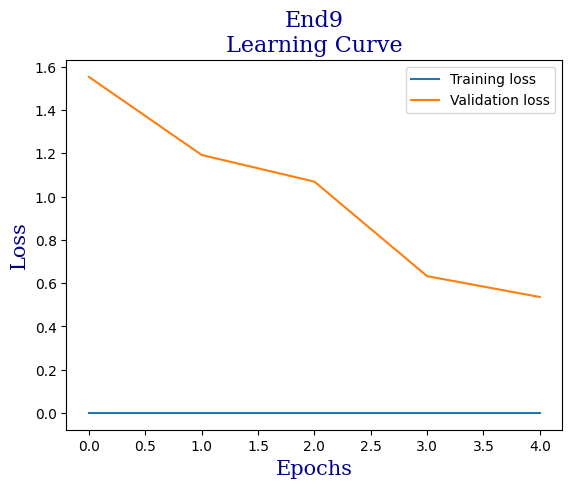

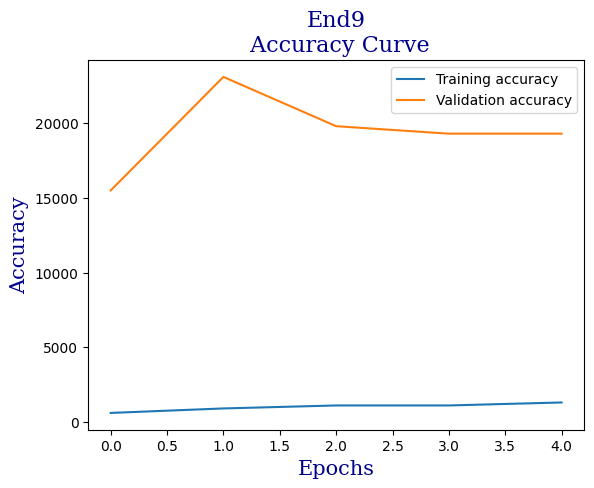

Accuracy of the network on the 2161 train images: 99 %
Accuracy of the network on the 241 validation images: 80 %


 12%|█████████████▉                                                                                                 | 1/8 [15:44<1:50:13, 944.76s/it]

Accuracy of the network on the 1030 test images: 83 %
EPOCH 1:
LOSS train 0.0 valid 1.6431481838226318
EPOCH 2:
LOSS train 0.0 valid 1.172762393951416
EPOCH 3:
LOSS train 0.0 valid 0.8260717391967773
EPOCH 4:
LOSS train 0.0 valid 0.7350864410400391
EPOCH 5:
LOSS train 0.0 valid 0.7267748713493347


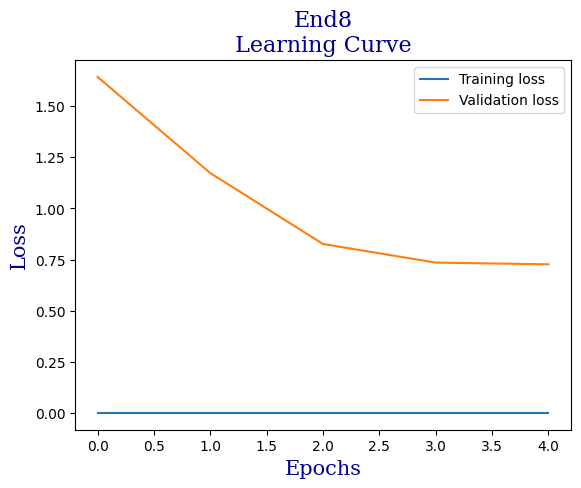

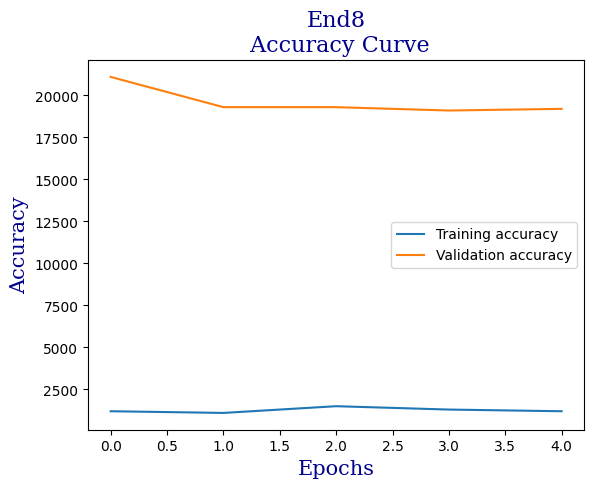

Accuracy of the network on the 2161 train images: 99 %
Accuracy of the network on the 241 validation images: 78 %


 25%|███████████████████████████▊                                                                                   | 2/8 [30:39<1:31:31, 915.32s/it]

Accuracy of the network on the 1030 test images: 82 %
EPOCH 1:
LOSS train 0.0 valid 1.946469783782959
EPOCH 2:
LOSS train 0.0 valid 1.5012441873550415
EPOCH 3:
LOSS train 0.0 valid 1.1862046718597412
EPOCH 4:
LOSS train 0.0 valid 0.9317783713340759
EPOCH 5:
LOSS train 0.0 valid 0.9011051058769226


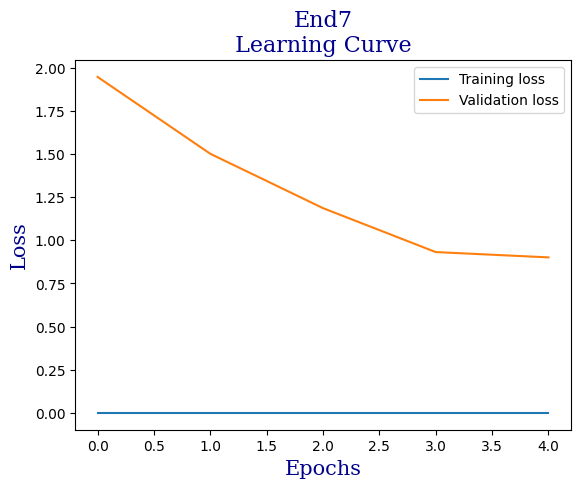

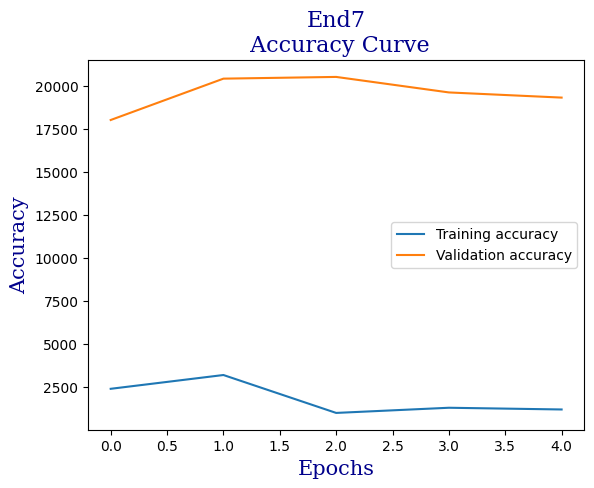

Accuracy of the network on the 2161 train images: 85 %
Accuracy of the network on the 241 validation images: 68 %


 38%|█████████████████████████████████████████▋                                                                     | 3/8 [40:57<1:04:58, 779.68s/it]

Accuracy of the network on the 1030 test images: 70 %
EPOCH 1:
LOSS train 0.0 valid 1.5153472423553467
EPOCH 2:
LOSS train 0.0 valid 1.1479454040527344
EPOCH 3:
LOSS train 0.0 valid 0.8404353260993958
EPOCH 4:
LOSS train 0.0 valid 0.7082337737083435
EPOCH 5:
LOSS train 0.0 valid 0.7593730092048645


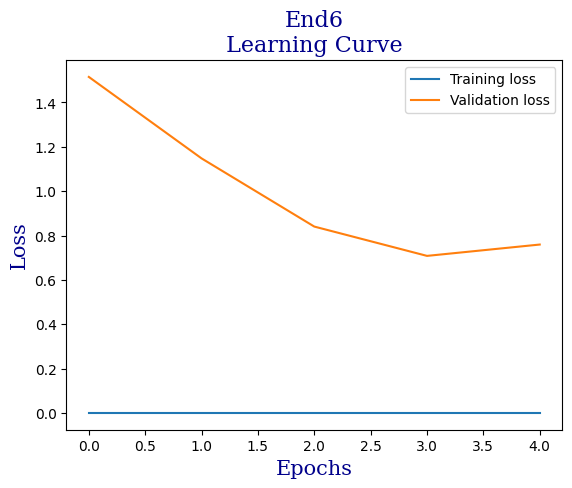

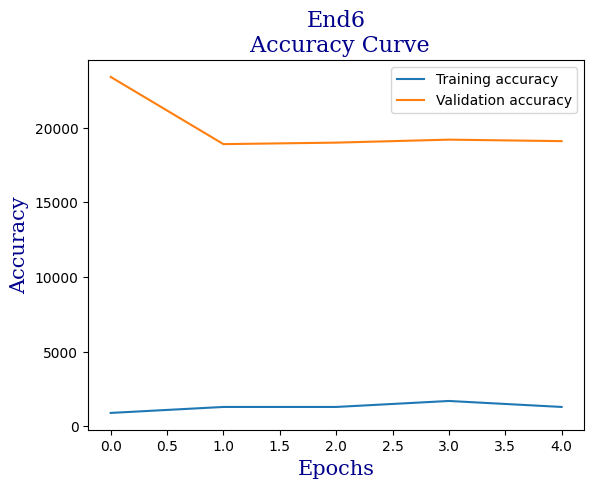

Accuracy of the network on the 2161 train images: 99 %
Accuracy of the network on the 241 validation images: 73 %


 50%|██████████████████████████████████████████████████████                                                      | 4/8 [1:05:42<1:10:31, 1057.86s/it]

Accuracy of the network on the 1030 test images: 76 %
EPOCH 1:
LOSS train 0.0 valid 1.6670398712158203
EPOCH 2:
LOSS train 0.0 valid 1.1357545852661133
EPOCH 3:
LOSS train 0.0 valid 0.9000409245491028
EPOCH 4:
LOSS train 0.0 valid 0.871843695640564
EPOCH 5:
LOSS train 0.0 valid 0.7334493398666382


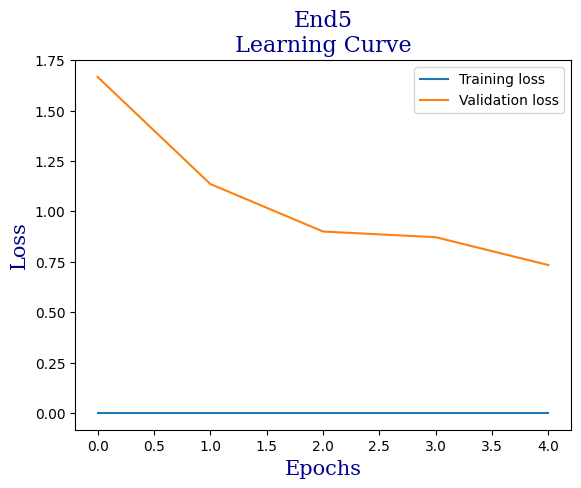

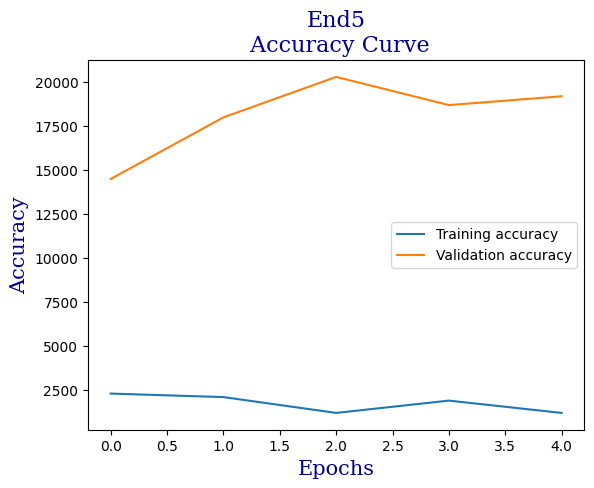

Accuracy of the network on the 2161 train images: 99 %
Accuracy of the network on the 241 validation images: 75 %


 62%|███████████████████████████████████████████████████████████████████▌                                        | 5/8 [1:30:57<1:01:08, 1222.86s/it]

Accuracy of the network on the 1030 test images: 75 %


 62%|████████████████████████████████████████████████████████████████████▊                                         | 5/8 [1:31:02<54:37, 1092.46s/it]

EPOCH 1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x135936 and 271872x4096)

In [19]:

front_accuracies = []
end_accuracies = []
epochs = 5
timestamp = datetime.now().strftime('%d%m%Y')



for i in tqdm(range(9, 1, -1)): #12
    #print("1 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    model_testing_layer_size = VGGTest(start_index=i, starting_side="end", conv_layers=convolution_layers)
    #print("1.1 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    model_testing_layer_size = model_testing_layer_size.to(mps_device)
    #ptrblk_fin_mod_size(model_testing_layer_size)
    #print(" 2 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_testing_layer_size.parameters(), lr=1.00E-05, weight_decay= 4e-5)
    schedulr = sch.ExponentialLR(optimizer, gamma=0.9)
    #print(" 2.2 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

    train_model(model_testing_layer_size, dataloaders, schedulr, optimizer, criterion, str(i), "End", epochs)
    #ptrblk_fin_mod_size(model_testing_layer_size)
    #print("3 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    #end_accuracies.append(test_model(model_testing_layer_size, dataloaders))

    results_to_csv = {
        "Starting Side": "End",
        "Layer Size" : str(i),
        "Epoch": epochs,
        "Loss" : "Cross Entropy Loss",
        "Optimizer" : "Adam",
        "Learning Rate": "1.00E-05",
        "Wieght Decay": "4e-5",
        "Scheduler": "ExponentialLR",
        "Gamma": "0.9",
        "Train Accuracy": str(test_model_train(model_testing_layer_size, dataloaders)),
        "Validation Accuracy": str(test_model_validation(model_testing_layer_size, dataloaders)),
        "Test Accuracy": str(test_model(model_testing_layer_size, dataloaders)),
    }

    save2csv(results_to_csv,"ModelResults_{}".format(timestamp), save_loc) #antvis/antvis/optics/Kemal/saves
    torch.cuda.empty_cache()
    #clear_output()
    
    #ptrblk_fin_mod_size(model_testing_layer_size)
    #print("4 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    del model_testing_layer_size


for i in range(1, 12):
    model_testing_layer_size = VGGTest(start_index=i, starting_side="front", conv_layers=convolution_layers)
    model_testing_layer_size = model_testing_layer_size.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_testing_layer_size.parameters(), lr=1.00E-05, weight_decay= 4e-5)
    schedulr = sch.ExponentialLR(optimizer, gamma=0.9)

    train_model(model_testing_layer_size, dataloaders, schedulr, optimizer, criterion, str(13 - i), "Front", epochs)

    #front_accuracies.append(test_model(model_testing_layer_size, dataloaders))

    results_to_csv = {
        "Starting Side": "Front",
        "Layer Size" : str(i),
        "Epoch": epochs,
        "Loss" : "Cross Entropy Loss",
        "Optimizer" : "Adam",
        "Learning Rate": "1.00E-05",
        "Wieght Decay": "4e-5",
        "Scheduler": "ExponentialLR",
        "Gamma": "0.9",
        "Train Accuracy": str(test_model_train(model_testing_layer_size, dataloaders)),
        "Validation Accuracy": str(test_model_validation(model_testing_layer_size, dataloaders)),
        "Test Accuracy": str(test_model(model_testing_layer_size, dataloaders)),
    }

    save2csv(results_to_csv,"ModelResults_{}".format(timestamp), save_loc)
    torch.cuda.empty_cache()
    print("4 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

    ptrblk_fin_mod_size(model_testing_layer_size)
    del model_testing_layer_size
    
    clear_output()

In [ ]:
di = {'a':1, 'b':2, 'c':3}

save2csv(di,"testing".format(timestamp), r"/its/home/nn268/antvis/antvis/optics/Kemal/saves/")

changing batch size made no difference
added a flatten(start_dim=1)

added memory prints

changed some values in self.linear_layer_dimension list


changed save location, device type and data path



Added a print of images, just to check the images are processed correctly

24/04/24

edited learning curve to include the save location so that the files are saved
edited to include the accuracies per epoch and the function to graph them

edited the dict that goes into a csv to include a column that states which end the layers are removed from